## Yolo11 tests - visualizations of results

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
import os , sys
sys.path.append('..')
from pathlib import Path
cur_path = Path(os.getcwd()).parent
sam2_path = cur_path / 'sam2_octron'
sys.path.append(cur_path.as_posix())
from matplotlib import pyplot as plt
import cmasher as cmr
import numpy as np
import seaborn as sns
sns.set_theme(style='white')
%config InlineBackend.figure_format = 'retina'

In [4]:
from natsort import natsorted   
import pandas as pd
from datetime import datetime
import zarr
import cv2
from napari_pyav._reader import FastVideoReader


In [5]:
from octron.yolo_octron.yolo_octron import YOLO_octron
from octron.yolo_octron.helpers.yolo_checks import check_yolo_models
from octron.yolo_octron.helpers.training import collect_labels

In [6]:
from ultralytics import YOLO
from octron.sam2_octron.helpers.video_loader import probe_video, get_vfile_hash
from octron.yolo_octron.helpers.polygons import get_polygons, polygon_to_mask, find_objects_in_mask
from octron.yolo_octron.helpers.yolo_zarr import create_prediction_store, create_prediction_zarr

In [7]:
base_path = Path('/Users/horst/Documents/python/OCTRON/octron/notebooks').parent
models_yaml_path = base_path / 'yolo_octron/yolo_models.yaml'

# project_path = Path('/Users/horst/Downloads/octron_project_2_trained')
# assert project_path.exists()

In [8]:
yolo_octron = YOLO_octron(models_yaml_path=models_yaml_path)

Models folder /Users/horst/Documents/python/OCTRON/octron/yolo_octron/models exists.
Model file /Users/horst/Documents/python/OCTRON/octron/yolo_octron/models/yolo11m-seg.pt exists. Skipping download.
Model file /Users/horst/Documents/python/OCTRON/octron/yolo_octron/models/yolo11l-seg.pt exists. Skipping download.
Model file /Users/horst/Documents/python/OCTRON/octron/yolo_octron/models/yolo11x-seg.pt exists. Skipping download.


### Read in results

In [9]:
video_file_path = Path('/Users/horst/Downloads/octron_project/first_half.mp4')
save_dir = Path('/Users/horst/Downloads/octron_project/predictions/first_half_botsort')

In [10]:
video_dict = probe_video(video_file_path)
video_reader= FastVideoReader(video_file_path, read_format='rgb24')

File: /Users/horst/Downloads/octron_project/first_half.mp4
Codec: h264
Resolution: 1000 x 1000
Frame Rate: 7.0
Number of frames: 2036
Duration: 290.86 seconds


In [11]:
csvs = list(save_dir.rglob('*.csv'))
print(f"Found {len(csvs)} tracking CSV files")
zarr_files = list(save_dir.rglob('*.zarr'))
assert len(zarr_files) == 1, "Expected exactly one zarr file"
zarr_file = zarr_files[0]
print(f"Found zarr file: {zarr_file}")

Found 4 tracking CSV files
Found zarr file: /Users/horst/Downloads/octron_project/predictions/first_half_botsort/predictions.zarr


In [12]:
# Load zarr
store = zarr.storage.LocalStore(zarr_file, read_only=False)
root = zarr.open_group(store=store, mode='a')
print("Existing keys in zarr archive:", list(root.array_keys()))

Existing keys in zarr archive: ['8_masks', '3_masks', '5_masks', '1_masks']


In [13]:
def visualize_tracking_df(track_df,
                          mask_zarr, 
                          label, 
                          video_dict, 
                          plot_every_n_mask=1
                          ):
    
    dummy_mask = np.zeros((video_dict['height'], video_dict['width']))
    
    _, ax = plt.subplots(figsize=(4, 4))
    #Plot the track on the dummy mask
    
    ax.scatter(track_df['pos_x'], 
               track_df['pos_y'], 
               s=track_df['area']/400, 
               label=label, 
               alpha=.6
               )
    track_outline = np.zeros_like(dummy_mask)
    for frame_no in range(0, video_dict['num_frames'], plot_every_n_mask):
        mask = mask_zarr[frame_no,:,:]
        if mask[0,0] == -1:
            continue
        
        polygon_points = get_polygons(mask)
         # Check if polygon_points is valid
        if polygon_points is None or len(polygon_points) == 0:
            continue
            
        # Ensure polygon_points is properly formatted for cv2.polylines
        if isinstance(polygon_points, np.ndarray):
            # Convert to list of numpy arrays if it's a single array
            if len(polygon_points.shape) == 2:  # Single polygon
                polygon_points = [polygon_points]
            
            # Draw each polygon
            for poly in polygon_points:
                # Ensure the points are properly shaped and have integer coordinates
                if len(poly) > 2:  # Need at least 3 points to form a polygon
                    poly_reshaped = poly.reshape((-1, 1, 2)).astype(np.int32)
                    try:
                        track_outline = cv2.polylines(
                            img=track_outline.copy(), 
                            pts=[poly_reshaped],
                            isClosed=True, 
                            color=(255, 255, 255),  
                            thickness=2,
                        )
                    except Exception as e:
                        print(f"Error with polygon: {e}")
                        print(f"Polygon shape: {poly.shape}, dtype: {poly.dtype}")
    
    # Add the track outline to the main plot
    if np.any(track_outline > 0):
        ax.imshow(track_outline, cmap='gray_r', alpha=0.3)
    
    ax.legend()
    ax.set_xticks([]);
    ax.set_yticks([]);
    return ax

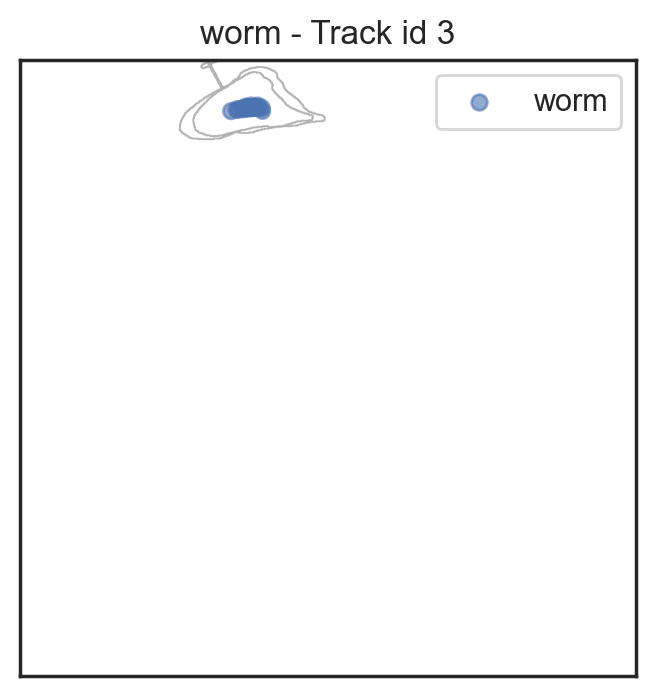

0.8897622105263158


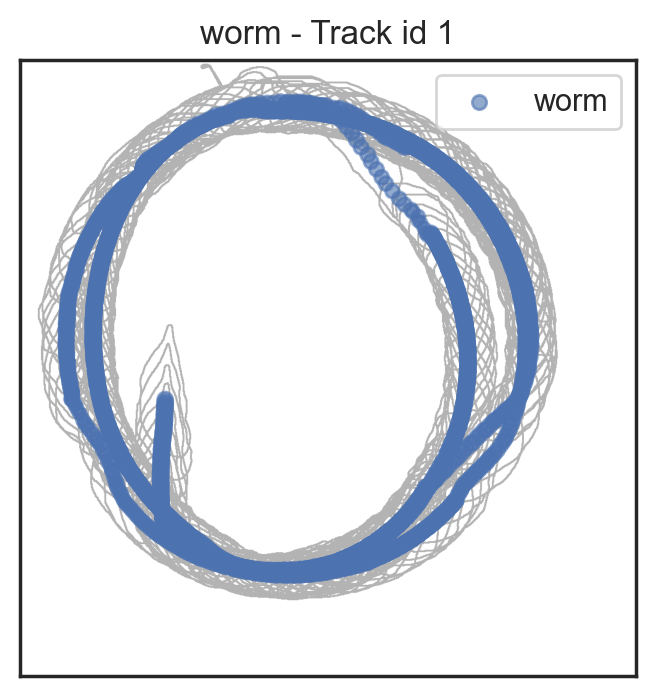

0.9317964115327748


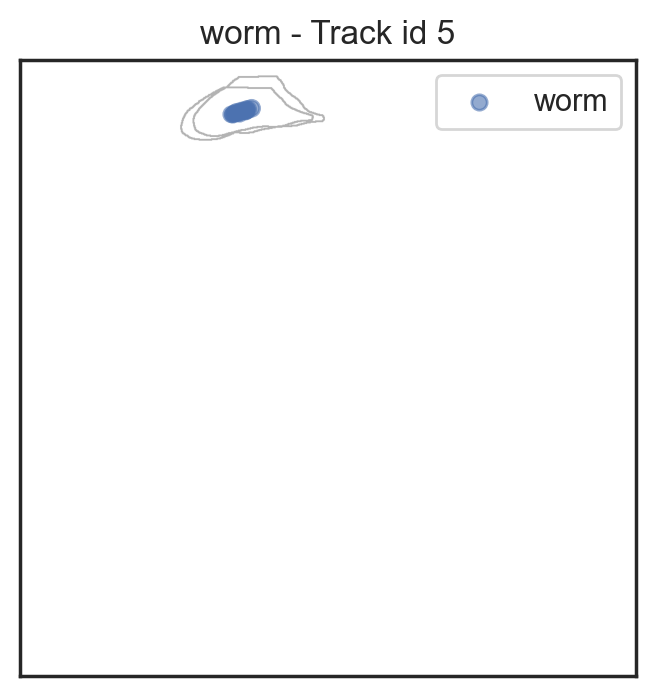

0.9021789599999999


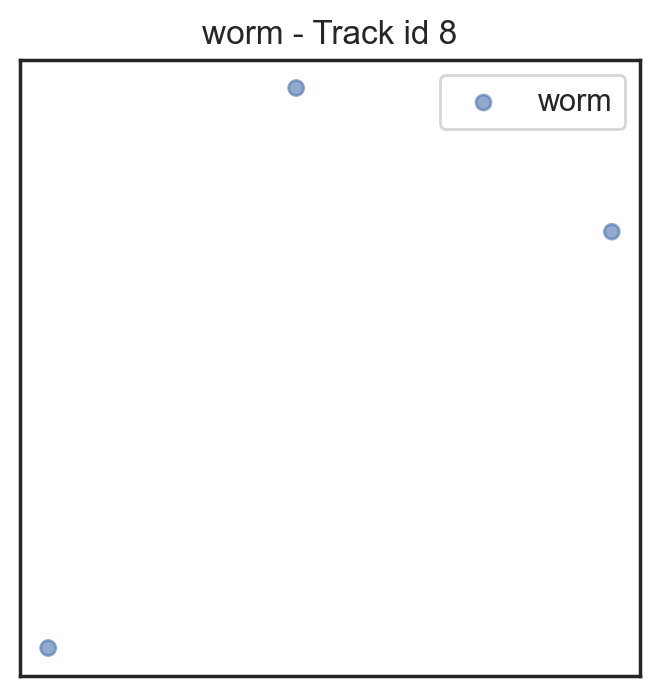

0.9047090333333334


In [14]:
# fig, ax = plt.subplots(1, 1, figsize=(6, 6))
# dummy_mask=np.zeros((video_dict['height'], video_dict['width']))
# ax.imshow(dummy_mask, cmap='gray')  
# plot_every_n_mask = 11
def find_class_by_name(classes, class_name):
    return (next((k for k, v in classes.items() if v == class_name), None))

# Color handling
from napari.utils import DirectLabelColormap
from octron.sam2_octron.helpers.sam2_colors import create_label_colors, sample_maximally_different
all_labels_submaps = create_label_colors(n_labels=10,
                                         n_colors_submap=50
                                         )
indices_max_diff_labels = sample_maximally_different(list(range(10)))
indices_max_diff_subcolors = sample_maximally_different(list(range(50)))


track_df_dict = {}
color_dict = {}
label_trackid_dict = {}
label_counter_dict = {} # This is to find the right color in all_labels_submaps

# Load the tracking data
for csv in save_dir.glob('*.csv'):
    track_df = pd.read_csv(csv)
    assert len(track_df.label.unique()) == 1, "Multiple labels found in tracking data"  
    assert len(track_df.track_id.unique()) == 1, "Multiple track_ids found in tracking data"  
    label = track_df.iloc[0].label
    track_id = track_df.iloc[0].track_id
    label_trackid_dict[label] = track_id
    
    # Check zarr
    assert f'{track_id}_masks' in list(root.array_keys()), "Mask not found in zarr archive" 
    mask_zarr = root[f'{track_id}_masks']
    classes = mask_zarr.attrs.get('classes', None) # These are the original classes from the model
    original_class_id = find_class_by_name(classes,label)
    # Check if an index was already given for the current label
    # This is to extract the right color from the colormap
    if label not in label_counter_dict:
        label_counter_dict[label] = {'track_counter' : 0}
    else:
        label_counter_dict[label]['track_counter'] += 1
    # Find color 
    obj_color =  all_labels_submaps[indices_max_diff_labels[int(original_class_id)]][indices_max_diff_subcolors[label_counter_dict[label]['track_counter']]]
    
    mask_colors = DirectLabelColormap(color_dict={None: [0.,0.,0.,0.], 1: obj_color}, 
                                              use_selection=True, 
                                              selection=1,
                                              )
        
        
    color_dict[int(track_id)] = mask_colors
    track_df_dict[int(track_id)] = track_df
    assert f'{track_id}_masks' in list(root.array_keys()), "Mask not found in zarr archive" 
    mask_zarr = root[f'{track_id}_masks']
    
    # Visualize
    ax = visualize_tracking_df(track_df, mask_zarr, label, video_dict, plot_every_n_mask=10)
    ax.set_title(f'{label} - Track id {track_id}') 
    plt.show()  
    print(track_df.confidence.mean())

### Add predictions back to napari 

In [30]:
from scipy.ndimage import gaussian_filter1d
import napari

In [31]:
viewer = napari.Viewer()    

layer_dict = {'name' : video_file_path.stem,
              'metadata': video_dict,
              }

add_layer = getattr(viewer, "add_image")
add_layer(video_reader, **layer_dict)

<Image layer 'first_half' at 0x34e33ef90>

In [54]:
sigmal_tracking_pos = 1
min_frame = 0
max_frame = video_dict['num_frames'] 

# Loop over each track and add it to the viewer
for track_id_to_plot in track_df_dict.keys():
    
    label = track_df_dict[track_id_to_plot].iloc[0].label   

    track_df_napari = track_df_dict[track_id_to_plot][['track_id','frame','pos_y','pos_x']].copy()
    features_df_napari = track_df_dict[track_id_to_plot][['frame','confidence','area','eccentricity','orientation','solidity']].copy()

    check_continuous = np.all(np.diff(track_df_napari['frame']) == 1)   
    if not check_continuous:
        #sys.exit()
        print("Frames are not continuous ... interpolating")
        complete_tracking   = pd.DataFrame({'frame': range(int(min_frame), int(max_frame))})
        complete_features   = pd.DataFrame({'frame': range(int(min_frame), int(max_frame))})
        # Merge with existing data to identify missing frames
        merged_df_tracking = complete_tracking.merge(track_df_napari, on='frame', how='left')
        merged_df_tracking['track_id'] = track_id_to_plot
        merged_df_features = complete_features.merge(features_df_napari, on='frame', how='left')
        
        # Make sure frame and track_id are the right types for interpolation
        merged_df_tracking['frame'] = merged_df_tracking['frame'].astype(int)
        merged_df_tracking['track_id'] = merged_df_tracking['track_id'].astype(int)

        # Interpolate the position columns
        pos_cols = ['pos_x', 'pos_y']
        for col in pos_cols:
            merged_df_tracking[col] = merged_df_tracking[col].interpolate(method='linear')

        # # For any remaining NaN values at the start or end, use forward/backward fill
        #merged_df_tracking = merged_df_tracking.ffill()
        #merged_df_tracking = merged_df_tracking.bfill()
        # After interpolation, get the valid frame indices from the tracking DataFrame
        valid_frames = merged_df_tracking.dropna()['frame'].values
        # Use these valid frames to filter both DataFrames
        merged_df_tracking = merged_df_tracking[merged_df_tracking['frame'].isin(valid_frames)].reset_index(drop=True)
        merged_df_features = merged_df_features[merged_df_features['frame'].isin(valid_frames)].reset_index(drop=True)
        # Double-check that the frames match
        assert np.array_equal(merged_df_tracking['frame'].values, merged_df_features['frame'].values), "Frame mismatch between tracking and features"

        
        track_df_napari = merged_df_tracking.copy()
        features_df_napari = merged_df_features.copy()
        
        # Before adding to Napari, change the column order
        track_df_napari = track_df_napari[['track_id', 'frame', 'pos_y', 'pos_x' ]]
        
    # Smooth the positions
    pos_cols = ['pos_x', 'pos_y']
    for col in pos_cols:
        track_df_napari[col] = gaussian_filter1d(track_df_napari[col], sigma=sigmal_tracking_pos)
        
    for col in features_df_napari.columns:
        features_df_napari[col] = features_df_napari[col].astype(float)
    features_dict = features_df_napari.to_dict(orient='list')
    
    
    # if track_id_to_plot == 1 :
    #     sys.exit()
    

    # Add tracks ... 
    viewer.add_tracks(track_df_napari.values, 
                      features=features_dict,
                       name=f'{label} - id {track_id_to_plot}', 
                      colormap='hsv',
                )
    viewer.layers[f'{label} - id {track_id_to_plot}'].tail_width = 5
    viewer.layers[f'{label} - id {track_id_to_plot}'].tail_length = 200
    viewer.layers[f'{label} - id {track_id_to_plot}'].color_by = 'frame'
    # Add masks
    mask_zarr = root[f'{track_id_to_plot}_masks']
    labels_layer = viewer.add_labels(
        mask_zarr,
        name=f'{label} - MASKS - id {track_id_to_plot}',  
        opacity=0.1,
        blending='additive',  
        colormap=color_dict[track_id_to_plot], 
    )
    
    viewer.layers[f'{label} - id {track_id_to_plot}'].tail_width = 4
    viewer.layers[f'{label} - id {track_id_to_plot}'].tail_length = 50

Frames are not continuous ... interpolating
Frames are not continuous ... interpolating
Frames are not continuous ... interpolating


/Users/horst/Documents/python/napari-pyav/src/napari_pyav/_reader.py:139: UserWarning: Seek problem with frame 2035! pts: 4169728; target: 4167680; dts: None; pict_type: 2
  warn_transcode(f'Seek problem with frame {frame_idx}! pts: {frame_obj.pts}; target: {target_pts}; dts: {frame_obj.dts}; pict_type: {str(frame_obj.pict_type)}')
/Users/horst/Documents/python/napari-pyav/src/napari_pyav/_reader.py:139: UserWarning: Consider transcoding (ffmpeg -y -i "input.mp4" -c:v libx264 -pix_fmt yuv420p -preset superfast -crf 23 "output.mp4").
  warn_transcode(f'Seek problem with frame {frame_idx}! pts: {frame_obj.pts}; target: {target_pts}; dts: {frame_obj.dts}; pict_type: {str(frame_obj.pict_type)}')


<Axes: xlabel='pos_x'>

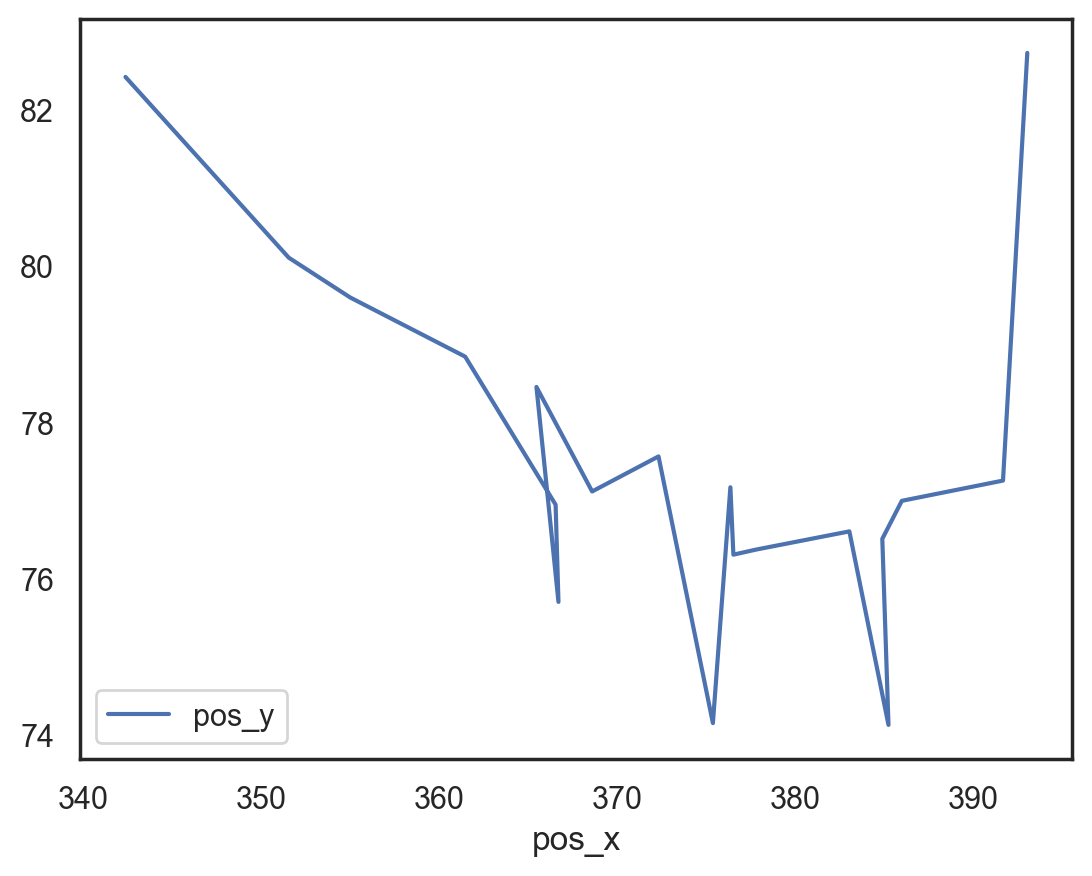

In [24]:
track_df_napari.plot(x='pos_x', y='pos_y')